In [45]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
# data preprocessing

import pandas as pd
import nltk
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
import string

# nltk.download('stopwords')


path = '/Users/admin/Downloads/DSA4263/reviews.csv'

raw = pd.read_csv(path)
data = pd.read_csv(path)

# lowercase words 

raw['Text'] = raw['Text'].apply(str.lower)

# remove stopwords using NLTK
stop_words = set(stopwords.words('english')) 
raw['no_stopwords'] = raw['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

# tokenize words using NLTK TweetTokenizer
tokenizer = TweetTokenizer()
raw['tokens'] = raw['no_stopwords'].apply(word_tokenize)

# lemmatization 
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in text]

raw['lemmatized'] = raw['tokens'].apply(lemmatize_text)


# remove punctuation
punctuations = list(string.punctuation)

def remove_punctuation(list):
    new_list = []
    for word in list:
        if word not in punctuations:
            new_list.append(word)
    return new_list

raw['cleaned'] = raw['lemmatized'].apply(remove_punctuation)

#remove short length words
def remove_short_words(words):
    return [word for word in words if len(word) > 2]
raw['removed_short_word'] = raw['cleaned'].apply(remove_short_words)

#convert amazon.com to amazon
def convert_strings(words):
    converted_words = []
    for word in words:
        if word == 'amazon.com':
            converted_words.append('amazon')
        else:
            converted_words.append(word)

    return converted_words

raw['converted_strings'] = raw['removed_short_word'].apply(convert_strings)

#remove contractions
def remove_contractions(words):
    contractions = ["'re", "'ve", "'d", "'m", "'ll", "n't"]
    new_words = []

    for word in words:
        # Check if the word is a contraction
        if any([word.endswith(c) for c in contractions]):
            continue
        else:
            # If it isn't a contraction, append the word to the new list as is
            new_words.append(word)
    return new_words

raw['remove_contractions'] = raw['converted_strings'].apply(remove_contractions)

import re

def remove_urls(words):
    # Define the regular expression pattern for URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    new_words = []

    for word in words:
        # Check if the word is a URL
        if not url_pattern.match(word):
            # If it isn't a URL, append the word to the new list
            new_words.append(word)

    return new_words
raw['remove_urls'] = raw['remove_contractions'].apply(remove_urls)

def remove_digits(words):
    new_words = []
    for word in words:
        if not any(char.isdigit() for char in word):
            new_words.append(word)

    return new_words


raw['remove_digits'] = raw['remove_urls'].apply(remove_digits)

def remove_ellipses(words):
    new_words = []
    for word in words:
        if "…" not in word:
            new_words.append(word)
    return new_words


raw['remove_ellipses'] = raw['remove_digits'].apply(remove_ellipses)

data['cleaned'] = raw['remove_ellipses']

data['cleaned'] = data['cleaned'].apply(' '.join)

In [47]:
data

,Sentiment,Time,Text,cleaned
0,positive,18/6/21,This is a very healthy dog food. Good for thei...,healthy dog food good digestion also good smal...
1,positive,7/7/21,I've been very pleased with the Natural Balanc...,pleased natural balance dog food dog issue dog...
2,positive,18/6/21,"Before I was educated about feline nutrition, ...",educated feline nutrition allowed cat become a...
3,positive,7/7/21,"My holistic vet recommended this, along with a...",holistic vet recommended this along brand trie...
4,positive,1/7/21,I bought this coffee because its much cheaper ...,bought coffee much cheaper ganocafe organic re...
...,...,...,...,...
5439,negative,26/2/21,"This is an okay gift box, only if you like med...",okay gift box like mediocre cheese summer saus...
5440,negative,18/12/19,It looks llike I just walked into a raw deal. ...,look llike walked raw deal item intolerably st...
5441,negative,19/1/20,Thank god that i tasted the metal before i swa...,thank god tasted metal swallowed them dont eve...
5442,negative,13/9/20,This product was very good when I began buying...,product good began buying lately terrible tast...


In [48]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['cleaned'])
sequences = tokenizer.texts_to_sequences(data['cleaned'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Label encoding
labels = np.array(data['Sentiment'].replace({'positive': 1, 'negative': 0}))

# train test split
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, stratify=labels)

# Build RNN model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 32),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {accuracy:.4f}')


Epoch 1/10
35/35 [==============================] - 4s 52ms/step - loss: 0.6125 - accuracy: 0.7139 - val_loss: 0.5738 - val_accuracy: 0.7401
Epoch 2/10
35/35 [==============================] - 1s 37ms/step - loss: 0.5688 - accuracy: 0.7403 - val_loss: 0.5723 - val_accuracy: 0.7401
Epoch 3/10
35/35 [==============================] - 1s 37ms/step - loss: 0.5668 - accuracy: 0.7403 - val_loss: 0.5720 - val_accuracy: 0.7401
Epoch 4/10
35/35 [==============================] - 1s 37ms/step - loss: 0.5648 - accuracy: 0.7417 - val_loss: 0.5722 - val_accuracy: 0.7401
Epoch 5/10
35/35 [==============================] - 1s 36ms/step - loss: 0.5609 - accuracy: 0.7527 - val_loss: 0.5666 - val_accuracy: 0.7401
Epoch 6/10
35/35 [==============================] - 1s 36ms/step - loss: 0.5110 - accuracy: 0.7506 - val_loss: 0.4724 - val_accuracy: 0.8044
Epoch 7/10
35/35 [==============================] - 1s 36ms/step - loss: 0.5577 - accuracy: 0.7656 - val_loss: 0.5759 - val_accuracy: 0.7410
Epoch 8/10
35

35/35 [==============================] - 1s 8ms/step


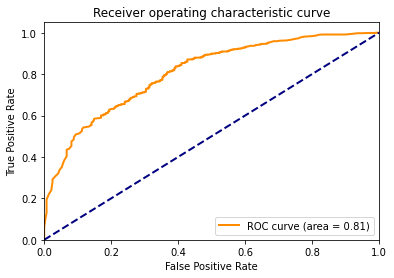

Precision: 0.85
Recall: 0.87
F1 score: 0.86


In [49]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Get predictions
y_pred = model.predict(x_test)

# Compute ROC curve and area under the curve (AUC)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Compute precision, recall, and F1 score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred.round(), average='binary')

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# Print precision, recall, and F1 score
print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1 score: {:.2f}'.format(f1_score))

In [50]:
y_pred = model.predict(x_test)
y_pred

35/35 [==============================] - 0s 7ms/step


array([[0.16438778],
       [0.84660465],
       [0.8466044 ],
       ...,
       [0.16438714],
       [0.8466046 ],
       [0.84660506]], dtype=float32)